In [1]:
from FeedForwardNN import Feedforward
from Toy_Datasets import two_clusters_gaussian
from Neural_Network import NLM
import autograd.numpy as np
from autograd import grad
import matplotlib.pyplot as plt
from autograd.misc.optimizers import adam
from Bayesian_pdf import get_log_prior, get_log_likelihood
from Hamiltonian_MC import hmc

In [2]:
def two_clusters_gaussian(params, n_samples, test_points=None):
    """
    :param params: should be a list of length K, K being the number of classes you wish to create
    for every class 0 <= k <=K-1, params[k] should be a dictionnary containing two keys: mean and covariance_matrix.
    The shapes expected for mean are D and covariance_matrix are D*D where D is the number of features for every
    datapoint.
    :param n_samples: number of samples you wish to create for every cluster
    :param test_points: OOD points
    :return: x of len(K*n_samples, n_features) and y of shape (K*n_samples). For both x and y, the features pertain
    sequentially to every class 0 <= k <= K-1
    """
    if params:
        if isinstance(params, list):  # params is a list
            K = len(params)
        else:  # params is a numpy array
            K = params.shape[0]	
        x = np.array([0, 0])
        for k, param in enumerate(params):
            param_k = params[k]
            try:
                mean_k, cov_k = param_k['mean'], param_k['covariance_matrix']
            except KeyError:
                raise KeyError('The parameters for class ' + str(k) + 'are not in the right dictionnary format. Please use mean and covariance_matrix')
            assert len(mean_k) == cov_k.shape[0] == cov_k.shape[1], 'Wrong shapes for the parameters of class ' + str(k)
            samples_class_k = np.random.multivariate_normal(mean_k, cov_k, n_samples)
            x = np.vstack((x, samples_class_k))
        y = np.array([[k] * n_samples for k in range(K)])
        return x[1:, :], np.array(y).flatten()
    else:
        raise BaseException().args

In [46]:
def plot_decision_boundary(x, y, models, ax, poly_degree=1, test_points=None, shaded=True):
    '''
    plot_decision_boundary plots the training data and the decision boundary of the classifier.
    input:
       x - a numpy array of size N x 2, each row is a patient, each column is a biomarker
       y - a numpy array of length N, each entry is either 0 (no cancer) or 1 (cancerous)
       models - an array of classification models
       ax - axis to plot on
       poly_degree - the degree of polynomial features used to fit the model
       test_points - test data
       shaded - whether or not the two sides of the decision boundary are shaded
    returns: 
       ax - the axis with the scatter plot

    '''
    # Plot data
    ax.scatter(x[y == 1, 0], x[y == 1, 1], alpha=0.2, c='red', label='class 1')
    ax.scatter(x[y == 0, 0], x[y == 0, 1], alpha=0.2, c='blue', label='class 0')
    ax.scatter(x[y == 2, 0], x[y == 2, 1], alpha=0.2, color='green', label='class 2')


    # Create mesh
    interval = np.arange(-5, 5, 0.1)
    n = np.size(interval)
    print(n)
    x1, x2 = np.meshgrid(interval, interval)
    x1 = x1.reshape(-1, 1)
    x2 = x2.reshape(-1, 1)
    xx = np.concatenate((x1, x2), axis=1)

    # Predict on mesh points
    if(poly_degree > 1):
        polynomial_features = PolynomialFeatures(degree=poly_degree, include_bias=True)
        xx = polynomial_features.fit_transform(xx)

    if len(models) > 1:
        alpha_line = 0.1
        linewidths=0.1
    else:
        alpha_line = 0.8
        linewidths=0.5

    i = 0

    for model in models:
        yy = model.predict(xx)  
        yy = yy.reshape((n, n))

        # Plot decision surface
        x1 = x1.reshape(n, n)
        x2 = x2.reshape(n, n)
        if shaded:
            ax.contourf(x1, x2, yy, alpha=0.1 * 1. / (i + 1)**2, cmap='bwr')
        ax.contour(x1, x2, yy, colors='black', linewidths=linewidths, alpha=alpha_line)

        i += 1

    if test_points is not None:
        for i in range(len(test_points)):
            pt = test_points[i]
            if i == 0:
                ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black', label='test data')
            else:
                ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black')

    ax.set_xlim((-5.5, 5.5))
    ax.set_ylim((-5.5, 5.5))
    ax.set_xlabel('x_1')
    ax.set_ylabel('x_2')
    ax.legend(loc='best')
    return ax

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

class Bayesian_logistic_regression:
    def __init__(self, intercept, slopes):
        self.intercept = intercept
        self.slopes = slopes

    def predict(self, x):
        print(x.shape)
        print(self.slopes.shape)
        #y = sigmoid((x.reshape(-1,20)).dot(self.slopes) + self.intercept)
        y = sigmoid((x).dot(self.slopes) + self.intercept)
        return (y > 0.5).astype(np.int_)

    def predict_proba(self, x):
        return sigmoid(x.dot(self.slopes) + self.intercept)

# test BNN
* 3 classes
* output dim =1
* 2000 samples, step size 1e-2


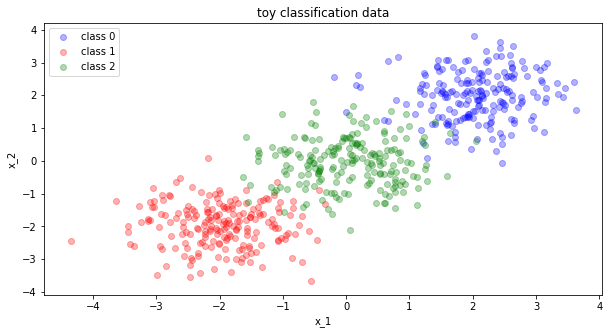

In [42]:
params_1 = {'mean': [2, 2], 'covariance_matrix': 0.5*np.eye(2)}
params_2 = {'mean': [-2, -2], 'covariance_matrix': 0.5 * np.eye(2)}
params_3 = {'mean': [0, 0], 'covariance_matrix': 0.5 * np.eye(2)}
params = [params_1, params_2,params_3]
x, y = two_clusters_gaussian(params, 200)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(x[y == 0, 0], x[y == 0, 1], alpha=0.3, color='blue', label='class 0')
ax.scatter(x[y == 1, 0], x[y == 1, 1], alpha=0.3, color='red', label='class 1')
ax.scatter(x[y == 2, 0], x[y == 2, 1], alpha=0.3, color='green', label='class 2')

ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.set_title('toy classification data')
ax.legend(loc='best')
plt.show()

In [20]:
###relu activation
activation_fn_type = 'relu'
activation_fn = lambda x: np.maximum(np.zeros(x.shape), x)


###neural network model design choices
width = 5
hidden_layers = 1
input_dim = 2
output_dim = 1

architecture = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'activation_fn_type': 'relu',
               'activation_fn_params': 'rate=1',
               'activation_fn': activation_fn}

#set random state to make the experiments replicable
rand_state = 0
random = np.random.RandomState(rand_state)

#instantiate a Feedforward neural network object
nn = Feedforward(architecture, random=random)

In [21]:
###define design choices in gradient descent
params = {'step_size':1e-3, 
          'max_iteration':15000, 
          'random_restarts':1}

#fit my neural network to minimize MSE on the given data
nn.fit(x.T, y.reshape(1,-1), params)

Iteration 0 lower bound [2791.86488256]; gradient mag: 1724.0802196725679
Iteration 100 lower bound [2278.47199913]; gradient mag: 1584.3345707291555
Iteration 200 lower bound [1794.30386289]; gradient mag: 1470.543305693521
Iteration 300 lower bound [1359.87501695]; gradient mag: 1212.9732584449168
Iteration 400 lower bound [1054.58474135]; gradient mag: 826.2045031181774
Iteration 500 lower bound [815.25533531]; gradient mag: 705.9920711012968
Iteration 600 lower bound [512.14382819]; gradient mag: 785.750931737315
Iteration 700 lower bound [187.42147817]; gradient mag: 796.1754191060468
Iteration 800 lower bound [-63.78081776]; gradient mag: 709.775822945812
Iteration 900 lower bound [-248.14371884]; gradient mag: 642.5214469380782
Iteration 1000 lower bound [-402.09047595]; gradient mag: 614.3961146760978
Iteration 1100 lower bound [-546.71334324]; gradient mag: 611.60230778777
Iteration 1200 lower bound [-692.58357353]; gradient mag: 626.9439503440082
Iteration 1300 lower bound [-

Iteration 10800 lower bound [-6337.6575678]; gradient mag: 7.666185576299966
Iteration 10900 lower bound [-6337.57942405]; gradient mag: 8.962374143182657
Iteration 11000 lower bound [-6337.55484213]; gradient mag: 8.638132262905133
Iteration 11100 lower bound [-6337.64688462]; gradient mag: 7.681124584222954
Iteration 11200 lower bound [-6337.62794147]; gradient mag: 7.966752555374169
Iteration 11300 lower bound [-6337.64610662]; gradient mag: 7.567824330567516
Iteration 11400 lower bound [-6337.63111751]; gradient mag: 7.825934556887013
Iteration 11500 lower bound [-6337.5441839]; gradient mag: 8.577649670864156
Iteration 11600 lower bound [-6337.58658264]; gradient mag: 8.623513737756076
Iteration 11700 lower bound [-6337.63104376]; gradient mag: 7.654344937462993
Iteration 11800 lower bound [-6337.62115296]; gradient mag: 7.853643393735601
Iteration 11900 lower bound [-6337.61986508]; gradient mag: 7.851944543651026
Iteration 12000 lower bound [-6337.62258778]; gradient mag: 7.7513

In [6]:
params_hmc={
       'num_samples':2000,
       'step_size':1e-2, 
       'L':20,
       'init': nn.weights,
       'burn':.1, 
       'thin':2,
}


def log_prior(W):
    Sigma=25*np.eye(nn.D)
    D_bayes=Sigma.shape[0]
    Sigma_inv= np.linalg.inv(Sigma)
    Sigma_det = np.linalg.det(Sigma)
    constant_W = -0.5 * (D_bayes * np.log(2 * np.pi) + np.log(Sigma_det))
    exponential_W = -0.5 * np.diag(np.dot(np.dot(W, Sigma_inv), W.T))
    log_p_W = constant_W + exponential_W
    return log_p_W

def log_likelihood(W):
    D_bayes=len(y.reshape((-1,1)))
    sigma_y=0.5
    constant = (-np.log(sigma_y) - 0.5 * np.log(2 * np.pi)) * D_bayes
    exponential = -0.5 * sigma_y**-2 * np.sum((y.reshape((1, 1, D_bayes)) - nn.forward(W, x.T))**2, axis=2).flatten()
    return constant + exponential



In [7]:
q=hmc(log_prior, log_likelihood, **params_hmc)

100 : 0.99 False
200 : 0.985 False
300 : 0.99 False
400 : 0.99 False
500 : 0.99 False
600 : 0.9916666666666667 False
700 : 0.9928571428571429 False
800 : 0.99375 False
900 : 0.9944444444444445 False
1000 : 0.995 False
1100 : 0.9945454545454545 False
1200 : 0.995 False
1300 : 0.9953846153846154 False
1400 : 0.995 False
1500 : 0.9953333333333333 False
1600 : 0.99375 False
1700 : 0.9941176470588236 False
1800 : 0.9938888888888889 False
1900 : 0.9942105263157894 False


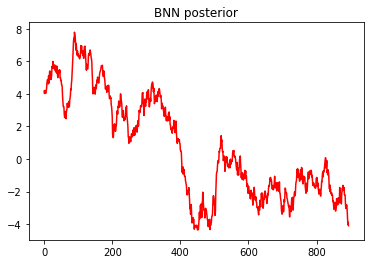

[[ 4.90307421  3.30941052 -0.6874437   0.18101156  4.35194973  2.39923358
  -1.23208785 -1.91308304  3.01321545  2.34666937 -7.04050418  6.19618163
  -5.57393894  5.01544207 -4.67388154 -3.28387082  4.38717042 -4.74624679
   4.18052495 -5.49290256  0.43372848]]


In [15]:
q_=np.asarray(q).T
plt.plot(range(len(q_[-1])),q_[-1] , color='r')
plt.title('BNN posterior')
plt.show()
print(nn.weights)

100
(10000, 2)
(20,)


ValueError: shapes (10000,2) and (20,) not aligned: 2 (dim 1) != 20 (dim 0)

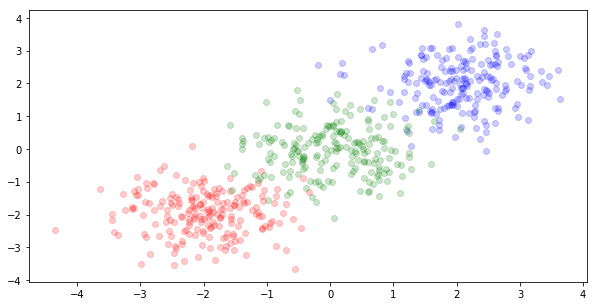

In [47]:
# Plot the decision boundary for the learned model
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
model=Bayesian_logistic_regression(nn.weights[0][-1],nn.weights[0][:-1])
ax = plot_decision_boundary(x, y, [model], ax, poly_degree=1,  shaded=True)
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.legend(loc='best')
plt.show()